In [43]:
# Imports
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [61]:
# Load in the dataset
df = pd.read_csv('coffee_orders.csv', encoding = "latin1")
df.head()


,Order ID,Customer ID,Location ID,Time of purchase,PreTax Total,Customer Order,Quantity
0,8848,3884,101,2024-11-06 16:34:27,3.80,Pain Au Chocolate:1:3.8,1
1,4925,3880,103,2024-11-05 16:58:36,5.02,Vegan Breakfast Roll:1:5.02,1
2,7898,7371,102,2024-11-07 09:44:52,12.14,Tiramisu Latte:2:4.34;Matcha Latte:1:3.46,3
3,9710,3884,104,2024-11-05 05:26:17,3.38,Caramel Frappe Latte:1:3.38,1
4,2790,5067,102,2024-11-07 09:16:49,4.95,Madeleines:1:4.95,1


# Preprocessing

In [60]:
# This groups all of a customers order into one line in the dataframe
# Group by Customer ID and aggregate
aggregated_df = df.groupby('Customer ID').agg({
    'Order ID': 'count',  # Number of orders for the customer
    'PreTax Total': 'sum',  # Sum up the total spent
    'Quantity': 'sum',  # Total quantity of items
    'Hour': 'mean',  # Average time of purchase
    'Day_of_week': lambda x: list(set(x)),  # Unique days the customer visited
    'Customer Order': lambda x: '; '.join(x)  # Combine all orders into a single string
}).reset_index()

# Rename columns for clarity
aggregated_df = aggregated_df.rename(columns={
    'Order ID': 'Total_Orders',
    'PreTax Total': 'Total_Spent',
    'Quantity': 'Total_Quantity',
    'Day_of_week': 'Unique_Visit_Days',
    'Customer Order': 'All_Orders'
})

# Display the resulting dataset
aggregated_df.head()


KeyError: "Column(s) ['Day_of_week', 'Hour'] do not exist"

In [11]:
def parse_customer_order(order):
    """
    This function takes in the customer order, and returns how many items they purchased.
    Arguments: 
        order(str): the customer order from the dataframe.
    Return:
        total_items(int): the number of items the customer ordered. 
    """
    items = order.split(';')
    total_items = len(items)
    return total_items

In [37]:
# We extract the number of items the customer ordered, and we extract the numerical features we calculated
aggregated_df['Num_Items'] = aggregated_df['All_Orders'].apply(parse_customer_order)
features = aggregated_df[['Total_Orders', 'Total_Spent', 'Total_Quantity']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


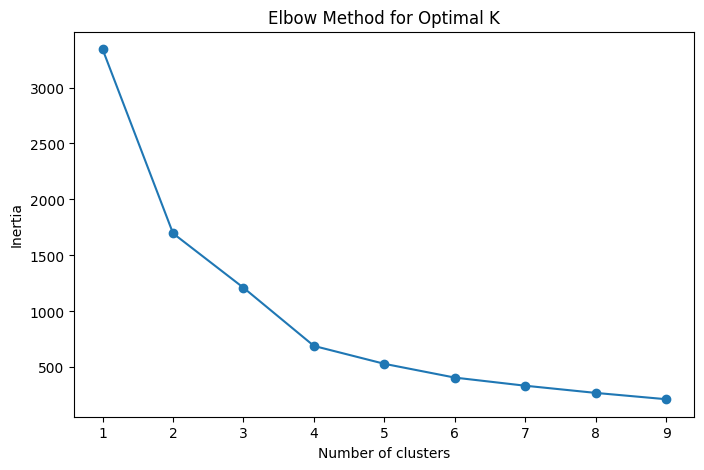

In [38]:
# Use the elbow method to determine the optimal number of clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [53]:
# Run kmeans on the features
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
aggregated_df['Cluster'] = kmeans.fit_predict(scaled_features)


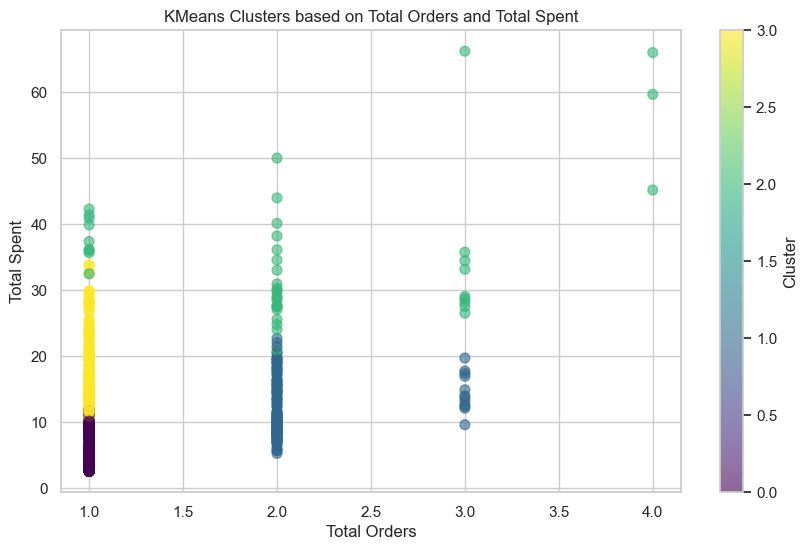

In [54]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the clusters using the first two principal components of the scaled features
plt.scatter(
    aggregated_df['Total_Orders'], aggregated_df['Total_Spent'], 
    c=aggregated_df['Cluster'], cmap='viridis', s=50, alpha=0.6
)

plt.title("KMeans Clusters based on Total Orders and Total Spent")
plt.xlabel("Total Orders")
plt.ylabel("Total Spent")
plt.colorbar(label='Cluster')
plt.show()

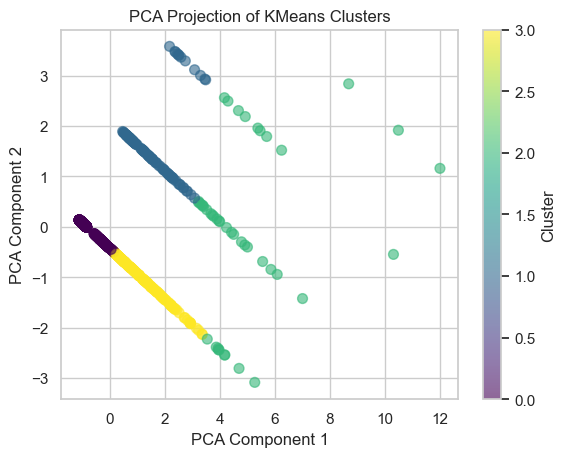

In [56]:
pca = PCA(n_components=3)
pca_features = pca.fit_transform(scaled_features)
plt.scatter(
    pca_features[:, 0], pca_features[:, 1], 
    c=aggregated_df['Cluster'], cmap='viridis', s=50, alpha=0.6
)

# Adding title and labels
plt.title("PCA Projection of KMeans Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()

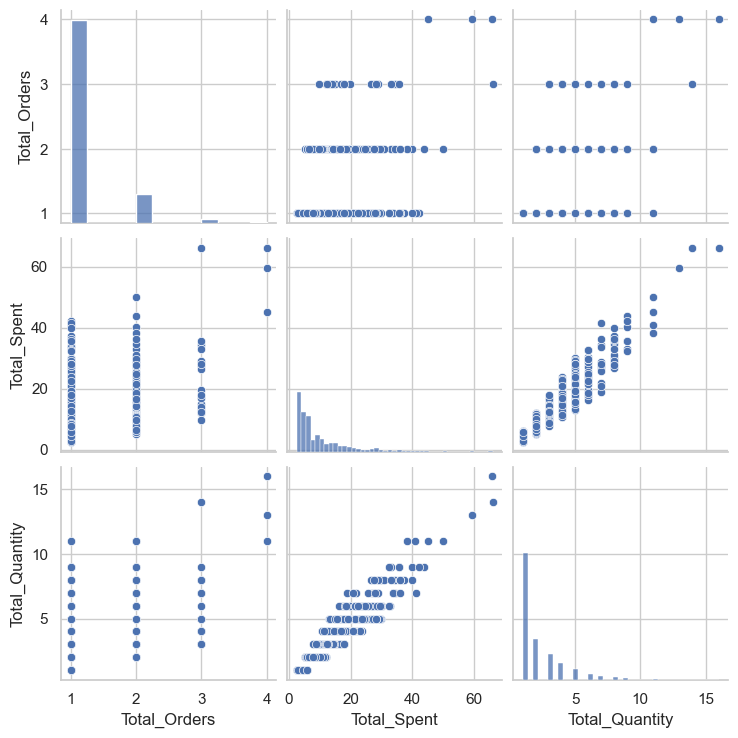